In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from keras import layers
from tensorflow.keras.applications.mobilenet import MobileNet
import matplotlib.gridspec as gridspec
from sklearn.metrics import classification_report, accuracy_score
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

import glob
import os
import random
import cv2

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download ashishjangra27/face-mask-12k-images-dataset

 95% 315M/330M [00:01<00:00, 166MB/s]
100% 330M/330M [00:02<00:00, 172MB/s]


In [ ]:
! unzip /content/face-mask-12k-images-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Face Mask Dataset/Train/WithoutMask/1855.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1856.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1857.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1858.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1859.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1860.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1861.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1862.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1863.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1864.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1865.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1866.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1867.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1868.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1869.png  
  inflating: Face Mask Dataset/Train/WithoutMask/

In [ ]:
## Declare Directory
train_dir = "/content/Face Mask Dataset/Train"
val_dir = "/content/Face Mask Dataset/Validation"
test_dir = "/content/drive/MyDrive/Test"

classes = ["With Mask", "Without Mask"]

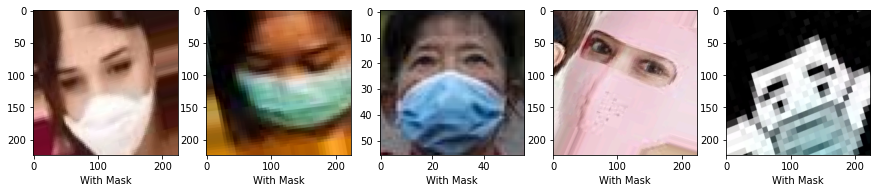

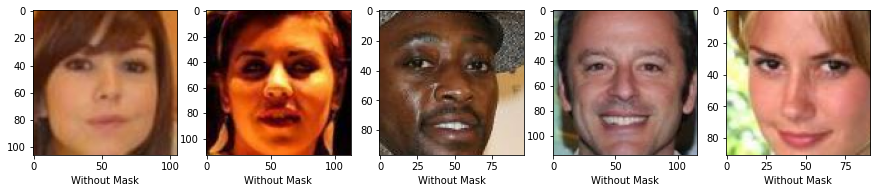

In [ ]:
n = 5
## Check Image
plt.figure(figsize=(15, n))
for i in range(n):
    # read image
    sample = random.choice(os.listdir(train_dir + "/WithMask"))
    # print("filename:", sample)
    img_dir = train_dir + "/WithMask/" + sample
    img = cv2.imread(img_dir)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # plot image
    plt.subplot(1, n, 1+i)
    plt.imshow(img)
    plt.xlabel("With Mask")
plt.show()   

plt.figure(figsize=(15, n))
for i in range(n):
    # read image
    sample = random.choice(os.listdir(train_dir + "/WithoutMask"))
    # print("filename:", sample)
    img_dir = train_dir + "/WithoutMask/" + sample
    img = cv2.imread(img_dir)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # plot image
    plt.subplot(1, n, 1+i)
    plt.imshow(img)
    plt.xlabel("Without Mask")
plt.show()

In [ ]:
# Dataset loader
train_datagen = ImageDataGenerator(
                                rescale=1./255,
                                rotation_range=0.2,
                                #width_shift_range=0.1,
                                #height_shift_range=0.1,
                                shear_range=0.2,
                                #zoom_range=0.09,
                                horizontal_flip=True,
                                vertical_flip=False,
                                #validation_split=0.1
                                )

val_datagen = ImageDataGenerator(rescale=1./255)

In [366]:
# Image Generator Config
target_size = (150, 150)
batch_size = 128

# Load Dataset
train_dataset = train_datagen.flow_from_directory(train_dir,
                                                  target_size=target_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=True)

val_dataset = val_datagen.flow_from_directory(val_dir,
                                              target_size=target_size,
                                              batch_size=batch_size,
                                              class_mode="categorical",
                                              shuffle=True)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [367]:
# Here is the model implementation
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential

my_model = Sequential()
my_model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', input_shape = (150, 150, 3)))
my_model.add(layers.MaxPooling2D((2, 2),strides=2))
my_model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = "same", strides = (2, 2))) 
my_model.add(layers.MaxPooling2D((2, 2),strides=2))               
my_model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
my_model.add(layers.MaxPooling2D((2, 2),strides=2))  
my_model.add(Dropout(0.3))
my_model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = "same"))
my_model.add(Flatten())
my_model.add(Dropout(0.3))
my_model.add(Dense(256, activation = 'relu'))
my_model.add(Dropout(0.4))
my_model.add(Dense(128, activation = 'relu'))
my_model.add(Dropout(0.5))
my_model.add(Dense(2, activation = 'softmax'))

In [368]:
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 64)        

In [369]:
from tensorflow.keras.optimizers import Adam
my_model.compile(optimizer=Adam(learning_rate=0.00001), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [370]:
batch_size= 128
epochs=10
learn_rate=.001

In [371]:
#Training the model
history = my_model.fit(x=train_dataset, epochs = epochs, validation_data = val_dataset)

Epoch 1/10
79/79 [==============================] - 52s 652ms/step - loss: 0.6782 - accuracy: 0.5745 - val_loss: 0.6256 - val_accuracy: 0.8275
Epoch 2/10
79/79 [==============================] - 52s 653ms/step - loss: 0.5651 - accuracy: 0.7693 - val_loss: 0.4180 - val_accuracy: 0.8675
Epoch 3/10
79/79 [==============================] - 51s 651ms/step - loss: 0.3977 - accuracy: 0.8552 - val_loss: 0.3153 - val_accuracy: 0.8875
Epoch 4/10
79/79 [==============================] - 51s 651ms/step - loss: 0.3179 - accuracy: 0.8898 - val_loss: 0.2753 - val_accuracy: 0.9062
Epoch 5/10
79/79 [==============================] - 51s 649ms/step - loss: 0.2771 - accuracy: 0.9055 - val_loss: 0.2479 - val_accuracy: 0.9187
Epoch 6/10
79/79 [==============================] - 51s 651ms/step - loss: 0.2504 - accuracy: 0.9139 - val_loss: 0.2269 - val_accuracy: 0.9237
Epoch 7/10
79/79 [==============================] - 51s 651ms/step - loss: 0.2328 - accuracy: 0.9226 - val_loss: 0.2077 - val_accuracy: 0.9275

In [543]:
test_dataset = val_datagen.flow_from_directory(test_dir,
                                            target_size=target_size,
                                            batch_size=1,
                                            class_mode=None,
                                            shuffle=False)

Found 1229 images belonging to 2 classes.


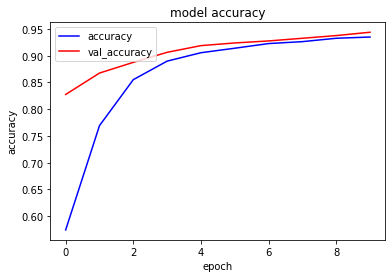

In [382]:
#Plotting the graphs for accuracy and validation_accuracy
plt.plot(history.history['accuracy'],"-b", label="accuracy")
plt.plot(history.history['val_accuracy'],"-r", label="val_accuracy")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

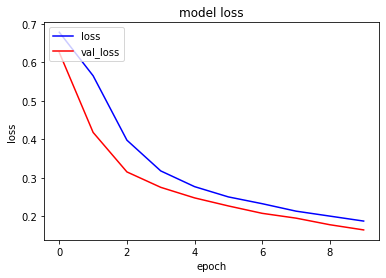

In [374]:
#Plotting the graphs for loss and validation_loss
plt.plot(history.history['loss'],"-b", label="loss")
plt.plot(history.history['val_loss'],"-r", label="val_loss")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

In [547]:
probabilities = my_model.predict_generator(test_dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [548]:
y_pred = probabilities.argmax(axis=-1)
y_test = test_dataset.classes

In [556]:
print("Test Accuracy Score of Model:", accuracy_score(y_pred,y_test))

Test Accuracy Score of Model: 0.8958502847843776


In [550]:
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

   With Mask       0.89      0.92      0.90       651
Without Mask       0.91      0.87      0.89       578

    accuracy                           0.90      1229
   macro avg       0.90      0.89      0.90      1229
weighted avg       0.90      0.90      0.90      1229



In [551]:
def preprocessing_img(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (150, 150))
    img = np.array(img)
    img = np.expand_dims(img, axis=0)
    img = img/255
    return img

/content/drive/MyDrive/Test/WithMask/women with face mask_18.jpeg


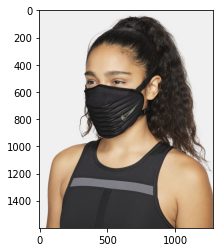

In [784]:
random_test_img = random.choice(glob.glob(test_dir+"/*/*"))
print(random_test_img)
img_test = cv2.imread(random_test_img)
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
plt.imshow(img_test)
plt.show()

In [785]:
img_test = preprocessing_img(img_test)
result = my_model.predict(img_test)
score = np.max(result)
predicted_class = classes[np.argmax(result)]
print(predicted_class)
print("Confident: ", score)

With Mask
Confident:  0.99921477
